### Import Library

In [41]:
from google.colab import drive
from IPython.display import Image, display

import pandas as pd
import spacy
import numpy as np

import re
import nltk
from nltk.corpus import stopwords
# nltk.download('punkt')
# nltk.download('stopwords')

from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter

from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

In [5]:
drive.mount('/content/drive')
file_path = '/content/drive/MyDrive/UTS TEXT MINING/data_1C.csv'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Read Dataset

In [6]:
df = pd.read_csv(file_path)
df.head()

,Unnamed: 0,text,label
0,0,"Aurion C3 Iron Curl Bar with 2 Locks, 3 ft (Si...",Household
1,1,"Presto 06620 11-Inch Electric Skillet Fries, g...",Household
2,2,WHOOSH! Award-Wining Screen Cleaner - Safe for...,Electronics
3,3,ManQ Men's Blended Waist Coat,Clothing & Accessories
4,4,Lace And Me Women's Blended High Waist Tummy &...,Clothing & Accessories


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12606 entries, 0 to 12605
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  12606 non-null  int64 
 1   text        12606 non-null  object
 2   label       12606 non-null  object
dtypes: int64(1), object(2)
memory usage: 295.6+ KB


In [8]:
# Hapus kolom yang ga diperluin
df = df.drop(columns=['Unnamed: 0'])
df.head()

,text,label
0,"Aurion C3 Iron Curl Bar with 2 Locks, 3 ft (Si...",Household
1,"Presto 06620 11-Inch Electric Skillet Fries, g...",Household
2,WHOOSH! Award-Wining Screen Cleaner - Safe for...,Electronics
3,ManQ Men's Blended Waist Coat,Clothing & Accessories
4,Lace And Me Women's Blended High Waist Tummy &...,Clothing & Accessories


In [9]:
df['label'].value_counts()

,count
label,
Household,4831
Books,2961
Electronics,2670
Clothing & Accessories,2144


Distribusi kelasnya menunjukkan bahwa kategori Household punya jumlah data paling banyak (4,831), sementara Clothing & Accessories paling sedikit (2,144). Karena dataset ini ngga seimbang, nanti waktu split data perlu pakai stratify. Ini penting supaya proporsi kelas di data training dan test tetap mirip dengan distribusi aslinya. Dengan begitu, semua kategori tetap terwakili secara adil di kedua set, jadi model bisa belajar dan diuji dengan data yang lebih realistis.

### Clean the Data

In [10]:
def clean_comment(text):
    text = text.lower() # Convert teks ke huruf kecil
    text = text.encode('ascii', 'ignore').decode('ascii') # Remove emoji
    text = re.sub(r'http\S+|www.\S+', '', text) # Remove URLs
    text = re.sub(r'[^A-Za-z\s]', '', text) # Remove tanda baca, angka, dan karakter khusus, jadi cuman nyisain huruf dan spasi
    text = re.sub(r'\b\w\b', '', text) # Remove kata-kata yang terdiri dari 1 karakter aja
    text = re.sub(r'\s+', ' ', text).strip() # Remove spasi extra
    return text

df['cleaned_text'] = df['text'].apply(clean_comment)

In [11]:
df[['text', 'cleaned_text']].head()

,text,cleaned_text
0,"Aurion C3 Iron Curl Bar with 2 Locks, 3 ft (Si...",aurion iron curl bar with locks ft silver mm t...
1,"Presto 06620 11-Inch Electric Skillet Fries, g...",presto inch electric skillet fries grills stew...
2,WHOOSH! Award-Wining Screen Cleaner - Safe for...,whoosh awardwining screen cleaner safe for all...
3,ManQ Men's Blended Waist Coat,manq mens blended waist coat
4,Lace And Me Women's Blended High Waist Tummy &...,lace and me womens blended high waist tummy th...


Bisa dilihat bahwa teks sudah berhasil dibersihkan dengan baik. Semua huruf sudah seragam menjadi huruf kecil, emoji dan URL sudah hilang (jika ada), tanda baca dan angka juga sudah dihapus. Hasil akhirnya lebih rapi dan fokus pada kata-kata inti, tetapi masih ada beberapa kata-kata typo yang harus di handle lebih lanjut

### Remove Stopwords

In [12]:
# Define stopwords dengan bahasa English dari nltk
stop_words = set(stopwords.words('english'))

# Remove stopwords dari teks dan simpan hasilnya ke kolom 'remove_stopword_text' untuk perbandingan nanti
df['remove_stopword_text'] = df['cleaned_text'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))

df[['cleaned_text', 'remove_stopword_text']].head()

,cleaned_text,remove_stopword_text
0,aurion iron curl bar with locks ft silver mm t...,aurion iron curl bar locks ft silver mm thickn...
1,presto inch electric skillet fries grills stew...,presto inch electric skillet fries grills stew...
2,whoosh awardwining screen cleaner safe for all...,whoosh awardwining screen cleaner safe screens...
3,manq mens blended waist coat,manq mens blended waist coat
4,lace and me womens blended high waist tummy th...,lace womens blended high waist tummy thigh sha...


Hasil remove stopwords diatas nunjukin kalo stopwords seperti "with," "the," "to," dan kata-kata umum lainnya berhasil dihapus dari teks. Kolom `remove_stopword_text` kini berisi versi teks yang lebih bersih dan fokus pada kata-kata inti yang lebih relevan, sehingga informasi yang kurang penting dapat dihilangkan dan teks lebih siap untuk analisis selanjutnya.

### WordCloud Visualization

Visualisasi ini berguna untuk memahami apakah kata-kata yang sering muncul memang relevan dengan konteks data (deskripsi produk). Jika ada kata yang tidak relevan atau kurang informatif, bisa dipertimbangkan untuk menghapusnya.

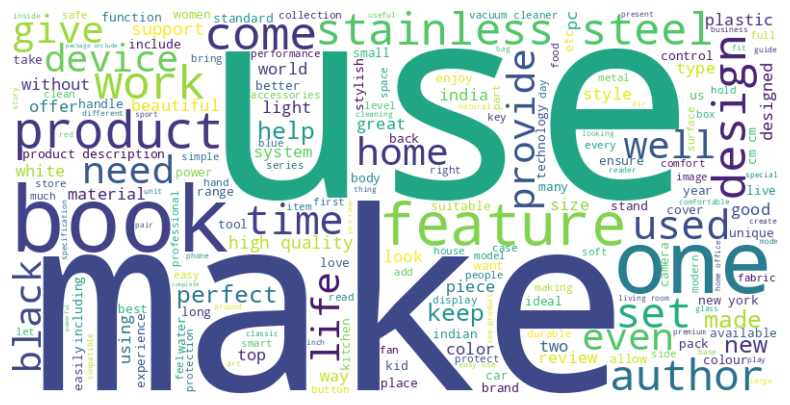

In [13]:
# Merge semua teks dalam kolom 'remove_stopword_text' jadi satu string
all_text = ' '.join(df['remove_stopword_text'].dropna())

wordcloud = WordCloud(width=800, height=400, background_color='white', random_state=42).generate(all_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [14]:
# Count total jumlah token unik
len(set(all_text.split()))

56707

In [15]:
# Count frekuensi kata dan tampilkan 10 kata paling sering
word_counts = Counter(all_text.split())
top_10_words = word_counts.most_common(10)
top_10_words

[('book', 3196),
 ('set', 3053),
 ('use', 2973),
 ('quality', 2778),
 ('easy', 2775),
 ('size', 2751),
 ('also', 2748),
 ('product', 2702),
 ('made', 2676),
 ('one', 2666)]

Dari total 55,850 token yang ada, kata-kata teratas seperti "book," "set," "use," "quality,", "product" dsb muncul sekitar 2,000 sampai 3,000 kali. Walaupun kata-kata ini cukup umum, frekuensinya ngga terlalu mendominasi keseluruhan data. Sebaliknya, kata-kata ini bisa membantu memberi konteks penting untuk memahami jenis dan kualitas produk. Jadi, sebaiknya kata-kata ini dibiarkan saja supaya deskripsi produk tetap utuh dan maknanya ngga hilang.

### Train-Test Split

Proses selanjutnya adalah lemmatization, yang bertujuan untuk mengubah setiap kata ke bentuk dasarnya agar teks lebih sederhana dan konsisten. Namun, sebelum itu, perlu dilakukan split data untuk mencegah kebocoran informasi dari data test ke data training.

Kalau lemmatization diterapkan ke seluruh dataset sebelum split, model bisa “mengintip” data test, yang seharusnya nggak boleh. Dengan split terlebih dahulu, kita memastikan lemmatization hanya dilakukan di data training, sehingga data test tetap murni untuk evaluasi yang lebih akurat.

In [16]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])

Penggunaan `stratify` diatas untuk mastiin proporsi setiap kelas dalam train dan test set mengikuti distribusi asli di dataset, sehingga representasi kelas tetap konsisten.

In [17]:
train_df['label'].value_counts()

,count
label,
Household,3864
Books,2369
Electronics,2136
Clothing & Accessories,1715


In [18]:
test_df['label'].value_counts()

,count
label,
Household,967
Books,592
Electronics,534
Clothing & Accessories,429


### Lemmatization

In [ ]:
# Inisialisasi model untuk English
nlp = spacy.load("en_core_web_sm")

text = "Kids are playing outside wearing waterproof jackets and running shoes, designed to handle tough weather."
doc = nlp(text)
lemmatized_text = ' '.join([token.lemma_ for token in doc])

print("Lemmatized Text:", lemmatized_text)

Lemmatized Text: kid be play outside wear waterproof jacket and running shoe , design to handle tough weather .


Hasil lemmatization dengan library SpaCy menunjukkan bahwa kata-kata dalam teks diubah ke bentuk dasarnya. Misalnya, "Kids" menjadi "kid," "playing" menjadi "play," dan "shoes" menjadi "shoe." Di balik proses ini, SpaCy sebenarnya menganalisis struktur setiap kata, termasuk tipe kata dan konteksnya, untuk menentukan bentuk dasar yang paling tepat. Hasil akhirnya adalah teks yang lebih simpel dan konsisten, dengan variasi bentuk kata yang dihilangkan tanpa mengurangi makna aslinya.

In [ ]:
# Lemmatization pada data training menggunakan SpaCy
train_df['lemmatized_text'] = train_df['remove_stopword_text'].apply(
    lambda x: ' '.join([token.lemma_ for token in nlp(x)])
)

# Lemmatization pada data test menggunakan SpaCy
test_df['lemmatized_text'] = test_df['remove_stopword_text'].apply(
    lambda x: ' '.join([token.lemma_ for token in nlp(x)])
)

In [ ]:
train_df[['remove_stopword_text', 'lemmatized_text']].head()

,remove_stopword_text,lemmatized_text
5136,philips hl watt mixer grinder jars black newly...,philips hl watt mixer grinder jar black newly ...
581,prophet author kahlil gibran author prophet le...,prophet author kahlil gibran author prophet le...
11789,smartcraft wooden paper towel holder brown medium,smartcraft wooden paper towel holder brown medium
1409,insight ecommerce silk georgette saree ie gown...,insight ecommerce silk georgette saree ie gown...
6446,network marketing millionaire,network marketing millionaire


In [ ]:
test_df[['remove_stopword_text', 'lemmatized_text']].head()

,remove_stopword_text,lemmatized_text
9751,cello ho bottle litre set colour may vary styl...,cello ho bottle litre set colour may vary styl...
7439,shag car travel air bed pvc inflatable mattres...,shag car travel air bed pvc inflatable mattres...
8279,scrafts brown square shaped traditional gold f...,scrafts brown square shape traditional gold fo...
4637,inovera label electric egg boiler steamer cum ...,inovera label electric egg boiler steamer cum ...
1345,inovu dual sim basic mobile phone bluegold upt...,inovu dual sim basic mobile phone bluegold upt...


In [19]:
train_path = '/content/drive/MyDrive/UTS TEXT MINING/train_df.csv'
test_path = '/content/drive/MyDrive/UTS TEXT MINING/test_df.csv'

# train_df.to_csv(train_path, index=False)
# test_df.to_csv(test_path, index=False)

train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

Karena proses lemmatization memakan waktu cukup lama, jadinya bisa disimpan dulu hasilnya ke file. Jadi, next ga perlu menjalankan ulang proses lemmatization lagi, cukup dengan mengimpor file yang sudah disimpan.

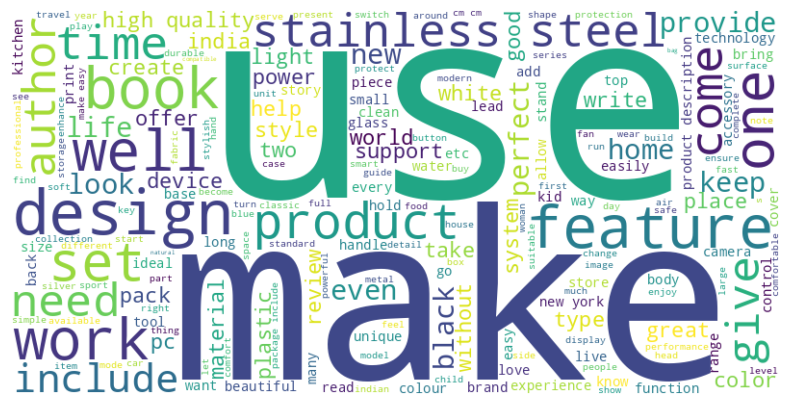

In [ ]:
all_text_new = ' '.join(train_df['lemmatized_text'].dropna())

wordcloud_new = WordCloud(width=800, height=400, background_color='white', random_state=42).generate(all_text_new)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_new, interpolation='bilinear')
plt.axis('off')
plt.show()

In [ ]:
# Top 10 kata setelah lemmatization
word_counts_new = Counter(all_text_new.split())
top_10_words_new = word_counts_new.most_common(10)
top_10_words_new

[('make', 5084),
 ('use', 4601),
 ('design', 3583),
 ('book', 3558),
 ('product', 3057),
 ('set', 2609),
 ('size', 2478),
 ('easy', 2370),
 ('one', 2362),
 ('quality', 2215)]

In [ ]:
# Top 10 kata sebelum lemmatization
top_10_words

[('book', 3196),
 ('set', 3053),
 ('use', 2973),
 ('quality', 2778),
 ('easy', 2775),
 ('size', 2751),
 ('also', 2748),
 ('product', 2702),
 ('made', 2676),
 ('one', 2666)]

Setelah lemmatization, bisa dilihat adanya perubahan jumlah kata untuk beberapa istilah. Misalnya, kata-kata seperti "made" dan "making" diubah menjadi bentuk dasarnya, "make," sehingga variasi kata yang sebelumnya terpisah kini digabungkan menjadi satu. Akibatnya, jumlah kemunculan kata dasar seperti "make" meningkat.

Proses ini bertujuan untuk menyederhanakan bentuk kata agar analisis bisa lebih fokus pada makna inti tanpa terganggu oleh variasi bentuk. Hasilnya, teks menjadi lebih konsisten, dan kata-kata utama lebih mudah ditangkap oleh model.

### Tokenization

In [ ]:
# Tokenisasi teks yang sudah melalui proses lemmatization
train_df['tokenized_text'] = train_df['lemmatized_text'].apply(lambda x: x.split())
test_df['tokenized_text'] = test_df['lemmatized_text'].apply(lambda x: x.split())

train_df[['lemmatized_text', 'tokenized_text']].head()

,lemmatized_text,tokenized_text
0,philips hl watt mixer grinder jar black newly ...,"[philips, hl, watt, mixer, grinder, jar, black..."
1,prophet author kahlil gibran author prophet le...,"[prophet, author, kahlil, gibran, author, prop..."
2,smartcraft wooden paper towel holder brown medium,"[smartcraft, wooden, paper, towel, holder, bro..."
3,insight ecommerce silk georgette saree ie gown...,"[insight, ecommerce, silk, georgette, saree, i..."
4,network marketing millionaire,"[network, marketing, millionaire]"


Hasil tokenisasi menunjukkan bahwa teks dalam kolom `lemmatized_text` berhasil dipecah menjadi list kata-kata dasar. Di kolom `tokenized_text`, bisa dilihat tiap teks sekarang berbentuk list kata, seperti "philips," "mixer," "grinder," dan seterusnya. Dengan bentuk ini, teks jadi lebih mudah untuk dianalisis atau diproses lebih lanjut, karena sudah terstruktur dalam token-token yang bisa diakses satu per satu.

## TF-IDF

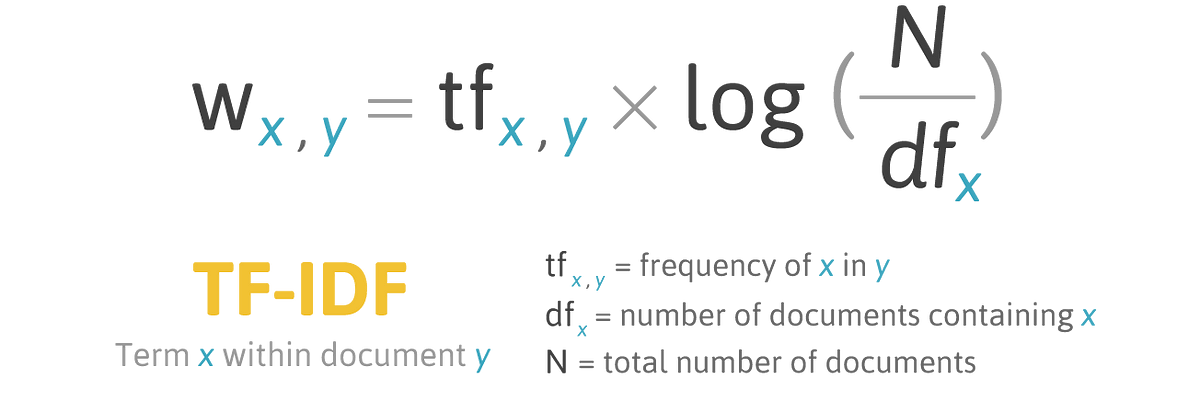

In [ ]:
display(Image(filename='/content/drive/MyDrive/UTS TEXT MINING/TFIDF2.png'))

*Source: https://medium.com/@rebirth4vali/tf-idf-from-scratch-with-python-e22033bb99f*

TF-IDF (Term Frequency-Inverse Document Frequency) adalah cara buat ngukur seberapa pentingnya sebuah kata di dalam dokumen, dibandingkan dengan seluruh dokumen lainnya dalam kumpulan data. Ini berguna biar bisa fokus ke kata-kata yang punya arti lebih spesifik dan ngabaikan kata-kata umum yang sering muncul tapi nggak terlalu informatif.

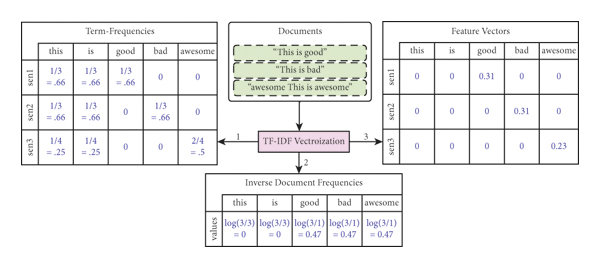

In [ ]:
display(Image(filename='/content/drive/MyDrive/UTS TEXT MINING/TFIDF.png'))

*Perhitungan pada Term-Frequencies ada sedikit kesalahan pada gambar, seharusnya 1/3 adalah 0.33. Namun, untuk hasil perkalian TF x IDF sudah benar (bisa dilihat pada table Feature Vectors). Jadi, untuk kasus diatas anggep aja kalo 1/3 adalah 0.66 agar tidak membingungkan.*

*Source: https://www.researchgate.net/publication/354354484_Automated_Prediction_of_Good_Dictionary_EXamples_GDEX_A_Comprehensive_Experiment_with_Distant_Supervision_Machine_Learning_and_Word_Embedding-Based_Deep_Learning_Techniques/figures?lo=1&utm_source=google&utm_medium=organic*

Cara kerja TF-IDF dibagi menjadi tiga langkah utama:

1. **Term Frequency (TF):**
  
  Mengukur seberapa sering kata muncul dalam setiap dokumen. Misalnya, di pojok kiri atas pada gambar:
    - Di kalimat pertama ("This is good"), kata "this" muncul 1 kali dari total 3 kata, jadi TF-nya adalah 1/3 = 0.33.
    - Ini dilakukan untuk setiap kata dalam setiap kalimat.
2. **Inverse Document Frequency (IDF):**

  Mengukur seberapa unik atau jarang kata tersebut muncul di seluruh dokumen. Rumusnya pakai logaritma, seperti di bagian bawah gambar.
  - Di sini, misalnya, kata "good" muncul di 1 dari 3 kalimat, jadi nilai IDF untuk "good" dihitung sebagai log(3/1) ≈ 0.47.
  - Kata yang sering muncul di banyak dokumen, seperti "this" dan "is", akan memiliki IDF rendah karena kurang informatif. Sedangkan kata yang jarang muncul, seperti "awesome", memiliki IDF tinggi, menunjukkan kata ini lebih spesifik.
3. **Mengalikan TF dan IDF untuk Membentuk TF-IDF:**

  Setelah TF dan IDF didapatkan, kalikan keduanya untuk mendapatkan nilai TF-IDF per kata di setiap kalimat.

  - Misalnya, untuk kata "good" di kalimat pertama, TF adalah 0.33 dan IDF adalah 0.47. Jadi, TF-IDF-nya adalah 0.66 * 0.47 ≈ 0.31.
  - Hasil akhir dari proses ini adalah matriks TF-IDF (feature vectors) yang merepresentasikan seberapa penting setiap kata dalam setiap dokumen.

In [21]:
# Panggil TF-IDF Vectorizer
tfidf = TfidfVectorizer()

# Fit dan transform data training
X_train_tfidf = tfidf.fit_transform(train_df['lemmatized_text'])

# Transform data test menggunakan fitur yang sama dari data training
X_test_tfidf = tfidf.transform(test_df['lemmatized_text'])

# Pisahin label target untuk data training dan test
y_train = train_df['label']
y_test = test_df['label']

In [22]:
tfidf_df = pd.DataFrame(X_train_tfidf.toarray(), columns=tfidf.get_feature_names_out())
tfidf_df.head()

,aa,aaa,aaaaa,aaabattery,aaatype,aac,aacmpwavamr,aadhar,aadhunik,aadhya,...,zumba,zx,zxl,zxstage,zylish,zyme,zz,zzcab,zzuk,zzzz
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### A.1) Support Vector Classifier (Default)

Parameter Default:
- C = `1.0`: Mengatur seberapa ketat model menghindari kesalahan. Nilai 1.0 adalah keseimbangan antara fleksibilitas dan akurasi dalam memisahkan data.

- kernel = `rbf`: Menggunakan kernel Radial Basis Function (RBF), yang cocok untuk data yang lebih kompleks atau tidak linear, karena mampu membentuk batas pemisah yang melengkung.

- gamma = `scale`: Menentukan seberapa jauh pengaruh setiap titik data. Dengan scale, gamma dihitung otomatis berdasarkan data, sehingga membuat model lebih adaptif terhadap skala data.

In [44]:
svm_model_default = SVC(random_state = 42)
svm_model_default.fit(X_train_tfidf, y_train)

y_pred_svm_default = svm_model_default.predict(X_test_tfidf)

print("SVM Model Accuracy:", accuracy_score(y_test, y_pred_svm_default))
print("SVM Model Precision:", precision_score(y_test, y_pred_svm_default, average='weighted'))
print("SVM Model Recall:", recall_score(y_test, y_pred_svm_default, average='weighted'))
print("SVM Model F1 Score:", f1_score(y_test, y_pred_svm_default, average='weighted'))
print("\n")
print("SVM Classification Report:\n", classification_report(y_test, y_pred_svm_default))

SVM Model Accuracy: 0.9547977795400476
SVM Model Precision: 0.9553589565494276
SVM Model Recall: 0.9547977795400476
SVM Model F1 Score: 0.9547112055416437


SVM Classification Report:
                         precision    recall  f1-score   support

                 Books       0.96      0.95      0.96       592
Clothing & Accessories       0.98      0.95      0.96       429
           Electronics       0.97      0.91      0.94       534
             Household       0.94      0.98      0.96       967

              accuracy                           0.95      2522
             macro avg       0.96      0.95      0.95      2522
          weighted avg       0.96      0.95      0.95      2522



### A.2) Support Vector Classifier (Tuning 1)

Hyperparameter yang dituning:
- C = `0.5`: Nilai lebih kecil (0.5) memberikan toleransi lebih terhadap kesalahan, yang dapat membuat model lebih general dan menghindari overfitting.

- kernel = `linear`: Kernel linear digunakan ketika data dapat dipisahkan dengan garis lurus di ruang fitur. Cocok untuk data yang cukup sederhana atau linear.

- gamma = `auto`: Dengan auto, gamma diatur sesuai jumlah fitur dalam data. Ini penting untuk mengontrol kompleksitas model.

In [46]:
svm_model_1_1 = SVC(C=0.5, kernel='linear', gamma='auto', random_state = 42)
svm_model_1_1.fit(X_train_tfidf, y_train)

y_pred_svm_1_1 = svm_model_1_1.predict(X_test_tfidf)

print("SVM Model Accuracy:", accuracy_score(y_test, y_pred_svm_1_1))
print("SVM Model Precision:", precision_score(y_test, y_pred_svm_1_1, average='weighted'))
print("SVM Model Recall:", recall_score(y_test, y_pred_svm_1_1, average='weighted'))
print("SVM Model F1 Score:", f1_score(y_test, y_pred_svm_1_1, average='weighted'))
print("\n")
print("SVM Classification Report:\n", classification_report(y_test, y_pred_svm_1_1))

SVM Model Accuracy: 0.9544012688342586
SVM Model Precision: 0.9546216538614357
SVM Model Recall: 0.9544012688342586
SVM Model F1 Score: 0.9543116516164434


SVM Classification Report:
                         precision    recall  f1-score   support

                 Books       0.95      0.96      0.96       592
Clothing & Accessories       0.98      0.97      0.97       429
           Electronics       0.96      0.91      0.94       534
             Household       0.94      0.97      0.96       967

              accuracy                           0.95      2522
             macro avg       0.96      0.95      0.95      2522
          weighted avg       0.95      0.95      0.95      2522



### A.3) Support Vector Classifier (Tuning 2)

Hyperparameter yang dituning:
- C = `1.5`: Nilai yang lebih besar (1.5) membuat model lebih ketat terhadap kesalahan, sehingga model berusaha memisahkan data sebaik mungkin tetapi berisiko *overfitting*.

- kernel = `poly`: Kernel polinomial digunakan untuk data yang tidak dapat dipisahkan dengan garis lurus. Kernel ini membentuk batas pemisah yang lebih kompleks, cocok untuk data dengan pola yang lebih rumit.

- gamma = `scale`: Dengan scale, gamma dihitung otomatis berdasarkan data, sehingga membuat model lebih adaptif terhadap skala data.

In [47]:
svm_model_1_2 = SVC(C=1.5, kernel='poly', gamma='scale', random_state = 42)
svm_model_1_2.fit(X_train_tfidf, y_train)

y_pred_svm_1_2 = svm_model_1_2.predict(X_test_tfidf)

print("SVM Model Accuracy:", accuracy_score(y_test, y_pred_svm_1_2))
print("SVM Model Precision:", precision_score(y_test, y_pred_svm_1_2, average='weighted'))
print("SVM Model Recall:", recall_score(y_test, y_pred_svm_1_2, average='weighted'))
print("SVM Model F1 Score:", f1_score(y_test, y_pred_svm_1_2, average='weighted'))
print("\n")
print("SVM Classification Report:\n", classification_report(y_test, y_pred_svm_1_2))

SVM Model Accuracy: 0.8346550356859636
SVM Model Precision: 0.8783488395260541
SVM Model Recall: 0.8346550356859636
SVM Model F1 Score: 0.8357811588854581


SVM Classification Report:
                         precision    recall  f1-score   support

                 Books       0.98      0.71      0.82       592
Clothing & Accessories       0.99      0.75      0.86       429
           Electronics       0.98      0.75      0.85       534
             Household       0.71      0.99      0.83       967

              accuracy                           0.83      2522
             macro avg       0.92      0.80      0.84      2522
          weighted avg       0.88      0.83      0.84      2522



### B.1) Random Forest Classifier (Default)

Parameter Default:
- n_estimators = `100`: Jumlah decision trees dalam Random Forest. Defaultnya adalah 100 tree. Semakin banyak tree, model biasanya lebih stabil dan akurat.

- max_depth = `None`: Kedalaman maksimum setiap tree. Dengan default None, tree akan tumbuh hingga semua leaves hanya memiliki satu sampel atau tidak bisa lagi dipecah. Kedalaman tanpa batas bisa meningkatkan risiko overfitting.

- min_samples_split = `2`: Jumlah minimum sampel yang diperlukan untuk memecah (split) simpul pada tree. Defaultnya adalah 2, artinya setiap simpul dapat dipecah jika memiliki setidaknya 2 sampel.

In [48]:
rf_model_default = RandomForestClassifier(random_state = 42)
rf_model_default.fit(X_train_tfidf, y_train)

y_pred_rf_default = rf_model_default.predict(X_test_tfidf)

print("Random Forest Model Accuracy:", accuracy_score(y_test, y_pred_rf_default))
print("Random Forest Model Precision:", precision_score(y_test, y_pred_rf_default, average='weighted'))
print("Random Forest Model Recall:", recall_score(y_test, y_pred_rf_default, average='weighted'))
print("Random Forest Model F1 Score:", f1_score(y_test, y_pred_rf_default, average='weighted'))
print("\n")
print("Random Forest Classification Report:\n", classification_report(y_test, y_pred_rf_default))

Random Forest Model Accuracy: 0.9345757335448057
Random Forest Model Precision: 0.9358324370354163
Random Forest Model Recall: 0.9345757335448057
Random Forest Model F1 Score: 0.9344035137659392


Random Forest Classification Report:
                         precision    recall  f1-score   support

                 Books       0.93      0.95      0.94       592
Clothing & Accessories       0.96      0.94      0.95       429
           Electronics       0.96      0.87      0.92       534
             Household       0.91      0.96      0.93       967

              accuracy                           0.93      2522
             macro avg       0.94      0.93      0.94      2522
          weighted avg       0.94      0.93      0.93      2522



### B.2) Random Forest Classifier (Tuning 1)

Hyperparameter yang dituning:
- n_estimators = `150`: Semakin banyak tree, model biasanya lebih stabil dan akurat. Di sini, digunakan 150 tree.

- max_depth = `20`: Membatasi kedalaman tree membantu mencegah overfitting. Di sini, setiap tree hanya boleh sampai kedalaman 20.

- min_samples_split = `5`: Diatur ke 5 agar setiap simpul hanya dipecah jika memiliki setidaknya 5 sampel, yang membantu mencegah tree terlalu terpecah dan mengurangi overfitting.

In [49]:
rf_model_1_1 = RandomForestClassifier(n_estimators=150, max_depth=20, min_samples_split=5, random_state = 42)
rf_model_1_1.fit(X_train_tfidf, y_train)

y_pred_rf_1_1 = rf_model_1_1.predict(X_test_tfidf)

print("Random Forest Model Accuracy:", accuracy_score(y_test, y_pred_rf_1_1))
print("Random Forest Model Precision:", precision_score(y_test, y_pred_rf_1_1, average='weighted'))
print("Random Forest Model Recall:", recall_score(y_test, y_pred_rf_1_1, average='weighted'))
print("Random Forest Model F1 Score:", f1_score(y_test, y_pred_rf_1_1, average='weighted'))
print("\n")
print("Random Forest Classification Report:\n", classification_report(y_test, y_pred_rf_1_1))

Random Forest Model Accuracy: 0.8140364789849326
Random Forest Model Precision: 0.863032957404451
Random Forest Model Recall: 0.8140364789849326
Random Forest Model F1 Score: 0.8147223981650429


Random Forest Classification Report:
                         precision    recall  f1-score   support

                 Books       0.96      0.74      0.83       592
Clothing & Accessories       0.98      0.67      0.79       429
           Electronics       0.98      0.71      0.82       534
             Household       0.68      0.99      0.81       967

              accuracy                           0.81      2522
             macro avg       0.90      0.77      0.81      2522
          weighted avg       0.86      0.81      0.81      2522



### Random Forest Classifier (Tuning 2)

Hyperparameter yang dituning:
- n_estimators = `50`: Dengan 50 trees, model tetap stabil tetapi lebih cepat dibandingkan dengan jumlah trees yang lebih banyak.

- max_depth = `50`: Dengan kedalaman yang lebih besar (50), model memiliki kemampuan untuk menangkap pola yang lebih kompleks dalam data, namun ini juga meningkatkan risiko overfitting.

- min_samples_split = `3`: Diatur ke 3 agar setiap simpul hanya dipecah jika memiliki setidaknya 3 sampel, yang membantu mencegah tree terlalu terpecah dan mengurangi overfitting.

In [50]:
rf_model_1_2 = RandomForestClassifier(n_estimators=50, max_depth=50, min_samples_split=3, random_state = 42)
rf_model_1_2.fit(X_train_tfidf, y_train)

y_pred_rf_1_2 = rf_model_1_2.predict(X_test_tfidf)

print("Random Forest Model Accuracy:", accuracy_score(y_test, y_pred_rf_1_2))
print("Random Forest Model Precision:", precision_score(y_test, y_pred_rf_1_2, average='weighted'))
print("Random Forest Model Recall:", recall_score(y_test, y_pred_rf_1_2, average='weighted'))
print("Random Forest Model F1 Score:", f1_score(y_test, y_pred_rf_1_2, average='weighted'))
print("\n")
print("Random Forest Classification Report:\n", classification_report(y_test, y_pred_rf_1_2))

Random Forest Model Accuracy: 0.921887390959556
Random Forest Model Precision: 0.9260848331844519
Random Forest Model Recall: 0.921887390959556
Random Forest Model F1 Score: 0.9216279361753561


Random Forest Classification Report:
                         precision    recall  f1-score   support

                 Books       0.93      0.93      0.93       592
Clothing & Accessories       0.98      0.89      0.93       429
           Electronics       0.97      0.84      0.90       534
             Household       0.88      0.98      0.92       967

              accuracy                           0.92      2522
             macro avg       0.94      0.91      0.92      2522
          weighted avg       0.93      0.92      0.92      2522



## TF-IDF (min_df=5, max_df=0.95)

Pada percobaan *TF-IDF* sebelumnya, ditemukan banyak kolom yang berisi kata-kata unik yang tampaknya merupakan *typo* dan sepertinya kurang relevan. Untuk menangani masalah ini, saya membaca beberapa paper yang memberikan inspirasi dalam menerapkan parameter `TfidfVectorizer(min_df=5, max_df=0.95)`. Dengan pendekatan ini, diharapkan dapat menghilangkan kata-kata yang terlalu jarang muncul atau terlalu sering muncul (seperti kata umum yang tidak memberikan informasi penting) agar model dapat bekerja lebih efisien dan menghasilkan hasil yang lebih akurat.

Source:
- [1] S. H. Jayady and H. Antong, "Theme Identification using Machine Learning Techniques," Journal of Integrated and Advanced Engineering, vol. 1, no. 2, pp. 123-134, Sep. 2021, doi: 10.51662/jiae.v1i2.24
- [2] N. P. Shetty, B. Muniyal, A. Anand, S. Kumar, and S. Prabhu, "Predicting Depression Using Deep Learning and Ensemble Algorithms on Raw Twitter Data," International Journal of Electrical and Computer Engineering, vol. 10, no. 4, pp. 3751-3756, Aug. 2020, doi: 10.11591/ijece.v10i4.pp3751-3756

In [32]:
# Panggil TF-IDF Vectorizer
tfidf_2 = TfidfVectorizer(min_df=5, max_df=0.95)

# Fit dan transform data training
X_train_tfidf_2 = tfidf_2.fit_transform(train_df['lemmatized_text'])

# Transform data test menggunakan fitur yang sama dari data training
X_test_tfidf_2 = tfidf_2.transform(test_df['lemmatized_text'])

# Pisahin label target untuk data training dan test
y_train = train_df['label']
y_test = test_df['label']

In [31]:
tfidf_df_2 = pd.DataFrame(X_train_tfidf_2.toarray(), columns=tfidf_2.get_feature_names_out())
tfidf_df_2.head()

,aa,aaa,aac,aakrithi,aart,ab,abandon,abaya,abc,abdoman,...,zookeeper,zoological,zoology,zoom,zooming,zoook,zorbe,zucchini,zuckerberg,zz
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### A.) Support Vector Classifier

In [51]:
svm_model_tuned_tfidf = SVC(random_state = 42)
svm_model_tuned_tfidf.fit(X_train_tfidf_2, y_train)

y_pred_svm_tuned_tfidf = svm_model_tuned_tfidf.predict(X_test_tfidf_2)

print("SVM Model Accuracy:", accuracy_score(y_test, y_pred_svm_tuned_tfidf))
print("SVM Model Precision:", precision_score(y_test, y_pred_svm_tuned_tfidf, average='weighted'))
print("SVM Model Recall:", recall_score(y_test, y_pred_svm_tuned_tfidf, average='weighted'))
print("SVM Model F1 Score:", f1_score(y_test, y_pred_svm_tuned_tfidf, average='weighted'))
print("\n")
print("SVM Classification Report:\n", classification_report(y_test, y_pred_svm_tuned_tfidf))

SVM Model Accuracy: 0.9551942902458367
SVM Model Precision: 0.9556013628662124
SVM Model Recall: 0.9551942902458367
SVM Model F1 Score: 0.955122590487376


SVM Classification Report:
                         precision    recall  f1-score   support

                 Books       0.96      0.95      0.96       592
Clothing & Accessories       0.98      0.96      0.97       429
           Electronics       0.96      0.92      0.94       534
             Household       0.94      0.98      0.96       967

              accuracy                           0.96      2522
             macro avg       0.96      0.95      0.96      2522
          weighted avg       0.96      0.96      0.96      2522



### B.) Random Forest Classifier

In [52]:
rf_model_tuned_tfidf = RandomForestClassifier(random_state = 42)
rf_model_tuned_tfidf.fit(X_train_tfidf_2, y_train)

y_pred_rf_tuned_tfidf = rf_model_tuned_tfidf.predict(X_test_tfidf_2)

print("Random Forest Model Accuracy:", accuracy_score(y_test, y_pred_rf_tuned_tfidf))
print("Random Forest Model Precision:", precision_score(y_test, y_pred_rf_tuned_tfidf, average='weighted'))
print("Random Forest Model Recall:", recall_score(y_test, y_pred_rf_tuned_tfidf, average='weighted'))
print("Random Forest Model F1 Score:", f1_score(y_test, y_pred_rf_tuned_tfidf, average='weighted'))
print("\n")
print("Random Forest Classification Report:\n", classification_report(y_test, y_pred_rf_tuned_tfidf))

Random Forest Model Accuracy: 0.9361617763679619
Random Forest Model Precision: 0.9376384952825616
Random Forest Model Recall: 0.9361617763679619
Random Forest Model F1 Score: 0.9360850091419769


Random Forest Classification Report:
                         precision    recall  f1-score   support

                 Books       0.93      0.95      0.94       592
Clothing & Accessories       0.96      0.93      0.95       429
           Electronics       0.98      0.88      0.93       534
             Household       0.91      0.96      0.94       967

              accuracy                           0.94      2522
             macro avg       0.94      0.93      0.94      2522
          weighted avg       0.94      0.94      0.94      2522



## WORD2VEC (CBOW)

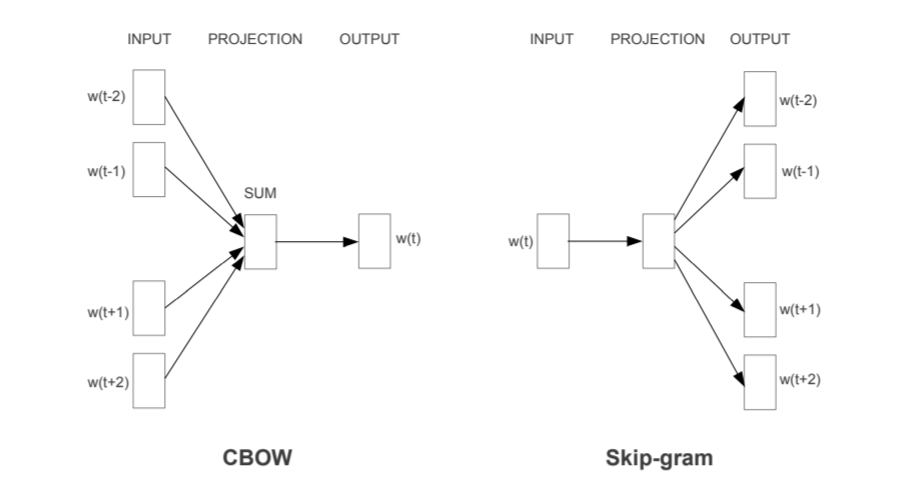

In [53]:
display(Image(filename='/content/drive/MyDrive/UTS TEXT MINING/Word2Vec.png'))

Cara kerja **CBOW (Continuous Bag of Words)** dalam Word2Vec berfokus pada prediksi kata target menggunakan kata-kata di sekitarnya (konteks), seperti yang ditunjukkan pada gambar sebelah kiri:

1. **Input**: Dalam CBOW, kata-kata di sekitar kata target (konteks) dimasukkan sebagai input. Pada gambar, kata-kata di sekitar kata target w(t) adalah w(t-2), w(t-1), w(t+1), dan w(t+2). Kata-kata ini dianggap sebagai "konteks" untuk kata target.

2. **Projection (Embedding Layer)**: Setiap kata dalam konteks dikonversi menjadi vektor, kemudian vektor-vektor ini dirata-ratakan (SUM pada gambar). Proses ini menghasilkan satu vektor representasi yang merangkum informasi dari kata-kata konteks.

3. **Output**: Vektor hasil perata-rataan dari konteks ini digunakan untuk memprediksi kata target w(t) melalui lapisan output. Dalam istilah machine learning, model mencoba "belajar" untuk mengenali kata target berdasarkan konteks kata-kata di sekitarnya.

Dalam proses training, CBOW menyesuaikan bobot vektor sehingga vektor kata yang muncul dalam konteks yang mirip akan berada lebih dekat di ruang vektor. Artinya, kata-kata yang sering muncul bersama akan memiliki vektor yang lebih mirip, yang berguna dalam banyak aplikasi NLP.

In [54]:
# Misahin teks menjadi token untuk Word2Vec
train_tokens = train_df['lemmatized_text'].apply(lambda x: x.split())
test_tokens = test_df['lemmatized_text'].apply(lambda x: x.split())

In [55]:
# Buat model Word2Vec
w2v_model = Word2Vec(sentences=train_tokens, vector_size=100, window=5, min_count=1, workers=4, sg=0)

Parameter Word2Vec diatas:
- vector_size = `100`: Ukuran vektor untuk setiap kata adalah 100 dimensi, yang akan menentukan seberapa detail representasi tiap kata.
- window = `5`: Jumlah kata di sekitar kata utama yang akan dipertimbangkan dalam konteks (5 kata di sebelah kiri dan kanan).
- min_count = `1`: Kata-kata yang muncul setidaknya 1 kali akan dimasukkan dalam model. Ini memastikan bahwa setiap kata dimasukkan, meskipun jarang muncul.
- workers = `4`: Menentukan jumlah core CPU yang digunakan untuk mempercepat proses training.
- sg = `0`: Menggunakan model CBOW (Continuous Bag of Words) sebagai arsitektur Word2Vec. Jika sg = `1`, model akan menggunakan arsitektur Skip-Gram.

In [56]:
# Function buat dapetin rata-rata vektor Word2Vec untuk setiap teks
def average_word_vectors(tokens_list, model, vector_size):
    vectorized_text = []
    for tokens in tokens_list:
        vectors = [model.wv[word] for word in tokens if word in model.wv]
        if vectors:
            avg_vector = np.mean(vectors, axis=0)
        else:
            avg_vector = np.zeros(vector_size)
        vectorized_text.append(avg_vector)
    return np.array(vectorized_text)

# Konversi teks jadi vektor dengan Word2Vec
X_train_w2v = average_word_vectors(train_tokens, w2v_model, vector_size=100)
X_test_w2v = average_word_vectors(test_tokens, w2v_model, vector_size=100)

Rata-rata vektor diambil karena setiap kata dalam teks punya vektor sendiri setelah diproses oleh Word2Vec. Jadi, di dalam satu kalimat atau dokumen, ada beberapa kata yang berarti juga ada beberapa vektor.

Supaya setiap dokumen bisa direpresentasikan dengan satu vektor yang tetap, perlu dirata-ratakan semua vektor kata di dalam dokumen itu. Dengan cara ini, dapat diperoleh satu vektor per dokumen yang mewakili keseluruhan isi dokumen. Hal ini sangat penting karena model machine learning seperti SVM atau Random Forest butuh input yang bentuknya konsisten, yaitu satu vektor per dokumen, bukan kumpulan vektor per kata.

In [60]:
X_train_w2v[:1]

array([[-4.6006656e-01, -8.8161238e-02,  2.0977278e-01,  1.1006889e-01,
        -4.1146588e-02, -1.0368166e+00,  5.4795805e-02,  7.3730832e-01,
        -1.6675749e-01, -3.7242019e-01, -2.1320999e-01, -1.1936173e+00,
        -2.7757964e-01,  4.6492428e-01,  7.2643526e-02, -2.2373392e-01,
         9.0955846e-02, -6.6685003e-01,  3.5428691e-01, -6.1358070e-01,
         5.2066827e-01,  3.1690249e-01,  4.5091804e-02, -3.2904962e-01,
         4.9521023e-01,  2.1217416e-01, -7.1684068e-01,  7.1277641e-02,
        -1.0151143e+00,  2.4100827e-01,  8.0813986e-01,  4.4557545e-01,
         5.3043697e-02, -4.7332007e-01, -3.7176102e-01,  4.2891002e-01,
         9.4447106e-02, -2.2916408e-01, -2.6743177e-01, -1.0667212e+00,
        -5.3821944e-02, -2.5779879e-01, -2.6600546e-01,  1.5996252e-01,
         1.7943944e-01, -1.2837516e-01, -8.7911296e-01, -4.6870355e-03,
         8.6870380e-03,  6.5756279e-01,  3.1428134e-01, -3.1385192e-01,
        -1.5603293e-01,  2.0353115e-01, -4.4933036e-01,  4.09546

Contoh baris pertama dari dokumen diatas adalah satu vektor dokumen dengan 100 elemen. Setiap elemen mewakili dimensi dalam ruang vektor yang dipelajari oleh model Word2Vec. Nilai-nilai ini menggambarkan "arti" atau konteks dari kata-kata dalam dokumen.

In [61]:
len(X_train_w2v)

10084

Terdapat 10,084 vektor, yang berarti ada 10,084 dokumen dalam data training. Setiap dokumen diwakili oleh satu vektor berdimensi 100, sehingga siap untuk dimasukkan ke dalam model machine learning sebagai input.

### A.1) Support Vector Classifier (Default)

Parameter Default:
- C = `1.0`: Mengatur seberapa ketat model menghindari kesalahan. Nilai 1.0 adalah keseimbangan antara fleksibilitas dan akurasi dalam memisahkan data.

- kernel = `rbf`: Menggunakan kernel Radial Basis Function (RBF), yang cocok untuk data yang lebih kompleks atau tidak linear, karena mampu membentuk batas pemisah yang melengkung.

- gamma = `scale`: Menentukan seberapa jauh pengaruh setiap titik data. Dengan scale, gamma dihitung otomatis berdasarkan data, sehingga membuat model lebih adaptif terhadap skala data.

In [62]:
svm_model_default_2 = SVC(random_state=42)
svm_model_default_2.fit(X_train_w2v, y_train)

y_pred_svm_default_2 = svm_model_default_2.predict(X_test_w2v)

print("SVM Model Accuracy:", accuracy_score(y_test, y_pred_svm_default_2))
print("SVM Model Precision:", precision_score(y_test, y_pred_svm_default_2, average='weighted'))
print("SVM Model Recall:", recall_score(y_test, y_pred_svm_default_2, average='weighted'))
print("SVM Model F1 Score:", f1_score(y_test, y_pred_svm_default_2, average='weighted'))
print("\n")
print("SVM Classification Report:\n", classification_report(y_test, y_pred_svm_default_2))

SVM Model Accuracy: 0.929024583663759
SVM Model Precision: 0.9292416127571754
SVM Model Recall: 0.929024583663759
SVM Model F1 Score: 0.9289634532855294


SVM Classification Report:
                         precision    recall  f1-score   support

                 Books       0.95      0.93      0.94       592
Clothing & Accessories       0.95      0.93      0.94       429
           Electronics       0.92      0.89      0.90       534
             Household       0.92      0.95      0.93       967

              accuracy                           0.93      2522
             macro avg       0.93      0.93      0.93      2522
          weighted avg       0.93      0.93      0.93      2522



### A.2) Support Vector Classifier (Tuning 1)

Hyperparameter yang dituning:
- C = `1.5`: Nilai yang lebih besar (1.5) membuat model lebih ketat terhadap kesalahan, sehingga model berusaha memisahkan data sebaik mungkin tetapi berisiko *overfitting*.

- kernel = `linear`: Kernel linear digunakan ketika data dapat dipisahkan dengan garis lurus di ruang fitur. Cocok untuk data yang cukup sederhana atau linear.

- gamma = `scale`: Dengan scale, gamma dihitung otomatis berdasarkan data, sehingga membuat model lebih adaptif terhadap skala data.

In [63]:
svm_model_2_1 = SVC(C=1.5, kernel='linear', gamma='scale', random_state = 42)
svm_model_2_1.fit(X_train_w2v, y_train)

y_pred_svm_2_1 = svm_model_2_1.predict(X_test_w2v)

print("SVM Model Accuracy:", accuracy_score(y_test, y_pred_svm_2_1))
print("SVM Model Precision:", precision_score(y_test, y_pred_svm_2_1, average='weighted'))
print("SVM Model Recall:", recall_score(y_test, y_pred_svm_2_1, average='weighted'))
print("SVM Model F1 Score:", f1_score(y_test, y_pred_svm_2_1, average='weighted'))
print("\n")
print("SVM Classification Report:\n", classification_report(y_test, y_pred_svm_2_1))

SVM Model Accuracy: 0.9298176050753371
SVM Model Precision: 0.9298736404795954
SVM Model Recall: 0.9298176050753371
SVM Model F1 Score: 0.9297116338145897


SVM Classification Report:
                         precision    recall  f1-score   support

                 Books       0.94      0.93      0.93       592
Clothing & Accessories       0.95      0.94      0.94       429
           Electronics       0.92      0.89      0.90       534
             Household       0.92      0.95      0.93       967

              accuracy                           0.93      2522
             macro avg       0.93      0.93      0.93      2522
          weighted avg       0.93      0.93      0.93      2522



### A.3) Support Vector Classifier (Tuning 2)

Hyperparameter yang dituning:
- C = `0.5`: Nilai lebih kecil (0.5) memberikan toleransi lebih terhadap kesalahan, yang dapat membuat model lebih general dan menghindari overfitting.

- kernel = `poly`: Kernel polinomial digunakan untuk data yang tidak dapat dipisahkan dengan garis lurus. Kernel ini membentuk batas pemisah yang lebih kompleks, cocok untuk data dengan pola yang lebih rumit.

- gamma = `auto`: Dengan auto, gamma diatur sesuai jumlah fitur dalam data. Ini penting untuk mengontrol kompleksitas model.

In [65]:
svm_model_2_2 = SVC(C=0.5, kernel='poly', gamma='auto', random_state = 42)
svm_model_2_2.fit(X_train_w2v, y_train)

y_pred_svm_2_2 = svm_model_2_2.predict(X_test_w2v)

print("SVM Model Accuracy:", accuracy_score(y_test, y_pred_svm_2_2))
print("SVM Model Precision:", precision_score(y_test, y_pred_svm_2_2, average='weighted'))
print("SVM Model Recall:", recall_score(y_test, y_pred_svm_2_2, average='weighted'))
print("SVM Model F1 Score:", f1_score(y_test, y_pred_svm_2_2, average='weighted'))
print("\n")
print("SVM Classification Report:\n", classification_report(y_test, y_pred_svm_2_2))

SVM Model Accuracy: 0.8544805709754163
SVM Model Precision: 0.8657064317185946
SVM Model Recall: 0.8544805709754163
SVM Model F1 Score: 0.852641022580448


SVM Classification Report:
                         precision    recall  f1-score   support

                 Books       0.87      0.94      0.90       592
Clothing & Accessories       0.95      0.75      0.84       429
           Electronics       0.93      0.72      0.81       534
             Household       0.79      0.93      0.85       967

              accuracy                           0.85      2522
             macro avg       0.88      0.83      0.85      2522
          weighted avg       0.87      0.85      0.85      2522



### B.1) Random Forest Classifier (Default)

Parameter Default:
- n_estimators = `100`: Jumlah decision trees dalam Random Forest. Defaultnya adalah 100 tree. Semakin banyak tree, model biasanya lebih stabil dan akurat.

- max_depth = `None`: Kedalaman maksimum setiap tree. Dengan default None, tree akan tumbuh hingga semua leaves hanya memiliki satu sampel atau tidak bisa lagi dipecah. Kedalaman tanpa batas bisa meningkatkan risiko overfitting.

- min_samples_split = `2`: Jumlah minimum sampel yang diperlukan untuk memecah (split) simpul pada tree. Defaultnya adalah 2, artinya setiap simpul dapat dipecah jika memiliki setidaknya 2 sampel.

In [66]:
rf_model_default_2 = RandomForestClassifier(random_state=42)
rf_model_default_2.fit(X_train_w2v, y_train)

y_pred_default_2 = rf_model_default_2.predict(X_test_w2v)

print("Random Forest Model Accuracy:", accuracy_score(y_test, y_pred_default_2))
print("Random Forest Model Precision:", precision_score(y_test, y_pred_default_2, average='weighted'))
print("Random Forest Model Recall:", recall_score(y_test, y_pred_default_2, average='weighted'))
print("Random Forest Model F1 Score:", f1_score(y_test, y_pred_default_2, average='weighted'))
print("\n")
print("Random Forest Classification Report:\n", classification_report(y_test, y_pred_default_2))

Random Forest Model Accuracy: 0.9405233941316415
Random Forest Model Precision: 0.9407281990236586
Random Forest Model Recall: 0.9405233941316415
Random Forest Model F1 Score: 0.9404955533012075


Random Forest Classification Report:
                         precision    recall  f1-score   support

                 Books       0.96      0.94      0.95       592
Clothing & Accessories       0.96      0.94      0.95       429
           Electronics       0.93      0.91      0.92       534
             Household       0.93      0.96      0.94       967

              accuracy                           0.94      2522
             macro avg       0.94      0.94      0.94      2522
          weighted avg       0.94      0.94      0.94      2522



### B.2) Random Forest Classifier (Tuning 1)

Hyperparameter yang dituning:
- n_estimators = `75`: Dengan 75 trees, model tetap stabil tetapi lebih cepat dibandingkan dengan jumlah trees yang lebih banyak.

- max_depth = `45`: Dengan kedalaman yang lebih besar (45), model memiliki kemampuan untuk menangkap pola yang lebih kompleks dalam data, namun ini juga meningkatkan risiko overfitting.

- min_samples_split = `4`: Diatur ke 4 agar setiap simpul hanya dipecah jika memiliki setidaknya 4 sampel, yang membantu mencegah tree terlalu terpecah dan mengurangi overfitting.

In [67]:
rf_model_2_1 = RandomForestClassifier(n_estimators=75, max_depth=45, min_samples_split=4, random_state = 42)
rf_model_2_1.fit(X_train_w2v, y_train)

y_pred_rf_2_1 = rf_model_2_1.predict(X_test_w2v)

print("Random Forest Model Accuracy:", accuracy_score(y_test, y_pred_rf_2_1))
print("Random Forest Model Precision:", precision_score(y_test, y_pred_rf_2_1, average='weighted'))
print("Random Forest Model Recall:", recall_score(y_test, y_pred_rf_2_1, average='weighted'))
print("Random Forest Model F1 Score:", f1_score(y_test, y_pred_rf_2_1, average='weighted'))
print("\n")
print("Random Forest Classification Report:\n", classification_report(y_test, y_pred_rf_2_1))

Random Forest Model Accuracy: 0.9425059476605868
Random Forest Model Precision: 0.9426931017047411
Random Forest Model Recall: 0.9425059476605868
Random Forest Model F1 Score: 0.942454083265949


Random Forest Classification Report:
                         precision    recall  f1-score   support

                 Books       0.96      0.94      0.95       592
Clothing & Accessories       0.96      0.95      0.95       429
           Electronics       0.93      0.91      0.92       534
             Household       0.93      0.96      0.95       967

              accuracy                           0.94      2522
             macro avg       0.95      0.94      0.94      2522
          weighted avg       0.94      0.94      0.94      2522



### B.3) Random Forest Classifier (Tuning 2)

Hyperparameter yang dituning:
- n_estimators = `200`: Semakin banyak tree, model biasanya lebih stabil dan akurat. Di sini, digunakan 200 tree.

- max_depth = `25`: Membatasi kedalaman tree membantu mencegah overfitting. Di sini, setiap tree hanya boleh sampai kedalaman 25.

- min_samples_split = `5`: Diatur ke 5 agar setiap simpul hanya dipecah jika memiliki setidaknya 5 sampel, yang membantu mencegah tree terlalu terpecah dan mengurangi overfitting.

In [68]:
rf_model_2_2 = RandomForestClassifier(n_estimators=200, max_depth=25, min_samples_split=5, random_state = 42)
rf_model_2_2.fit(X_train_w2v, y_train)

y_pred_rf_2_2 = rf_model_2_2.predict(X_test_w2v)

print("Random Forest Model Accuracy:", accuracy_score(y_test, y_pred_rf_2_2))
print("Random Forest Model Precision:", precision_score(y_test, y_pred_rf_2_2, average='weighted'))
print("Random Forest Model Recall:", recall_score(y_test, y_pred_rf_2_2, average='weighted'))
print("Random Forest Model F1 Score:", f1_score(y_test, y_pred_rf_2_2, average='weighted'))
print("\n")
print("Random Forest Classification Report:\n", classification_report(y_test, y_pred_rf_2_2))

Random Forest Model Accuracy: 0.9405233941316415
Random Forest Model Precision: 0.9407805847391522
Random Forest Model Recall: 0.9405233941316415
Random Forest Model F1 Score: 0.9404828114162781


Random Forest Classification Report:
                         precision    recall  f1-score   support

                 Books       0.95      0.94      0.94       592
Clothing & Accessories       0.96      0.94      0.95       429
           Electronics       0.93      0.91      0.92       534
             Household       0.93      0.96      0.94       967

              accuracy                           0.94      2522
             macro avg       0.94      0.94      0.94      2522
          weighted avg       0.94      0.94      0.94      2522



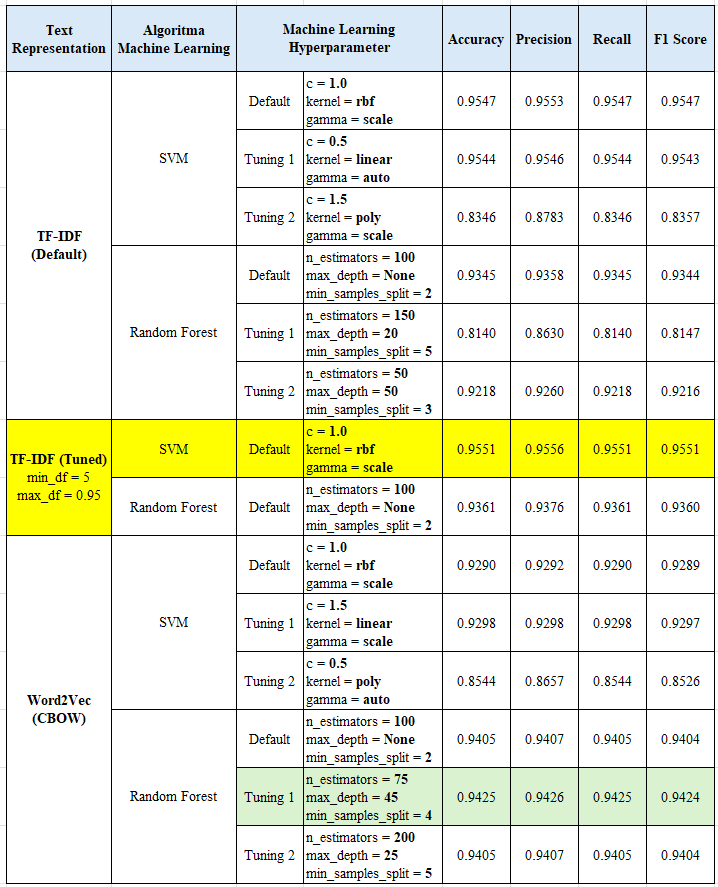

In [70]:
display(Image(filename='/content/drive/MyDrive/UTS TEXT MINING/Evaluation.png'))

## Analysis

### A.) Text Representation

Hasil evaluasi menunjukkan bahwa representasi teks **TF-IDF** memberikan performa terbaik dengan akurasi tertinggi sebesar **95.51%** dibandingkan **Word2Vec (CBOW)**. Hal ini karena TF-IDF di-tuning lebih lanjut pada parameter **min_df** dan **max_df**, yang membuatnya hanya mempertahankan kata-kata yang sering muncul dan relevan dalam konteks data. Dengan cara ini, TF-IDF dapat menangkap informasi yang benar-benar penting dan berkaitan langsung dengan kategori produk, sehingga hasil representasi teksnya lebih fokus dan informatif.

### B.) Machine Learning Model

Dari segi model machine learning, **SVM dengan kernel RBF (default) menggunakan TF-IDF** memberikan hasil terbaik dengan akurasi **95.51%**. Model SVM ini bekerja sangat baik karena kernel RBF mampu menangani data yang tidak sepenuhnya linear dengan memetakan data ke dimensi yang lebih tinggi. Dengan begitu, model ini bisa lebih mudah memisahkan kategori produk berdasarkan pola dari representasi TF-IDF, sehingga menghasilkan prediksi yang akurat.

Menariknya, **Random Forest dengan tuning 1 menggunakan Word2Vec CBOW** menghasilkan akurasi tertinggi kedua, yaitu **94.25%**. Pada konfigurasi ini, Random Forest menggunakan 75 estimators, max_depth 45, dan min_samples_split 4. Parameter ini membantu Random Forest menemukan keseimbangan yang optimal antara kompleksitas model dan generalisasi, sehingga model mampu menangani variasi dalam data e-commerce ini dengan cukup baik. Kombinasi Random Forest dan Word2Vec CBOW terbukti cukup efektif untuk data ini, meskipun hasilnya sedikit di bawah SVM dengan TF-IDF.

## Conclusion

Kesimpulannya, untuk data e-commerce ini, pendekatan TF-IDF dengan model SVM memberikan hasil paling akurat, terutama dengan pengaturan default yang sudah cukup optimal. Di sisi lain, kombinasi Word2Vec CBOW dan Random Forest dengan tuning juga menunjukkan hasil yang kuat sebagai alternatif, meskipun sedikit di bawah performa SVM. Dengan demikian, TF-IDF dan SVM menjadi pilihan utama, tetapi Random Forest dengan Word2Vec tetap solusi yang baik jika ingin mengeksplorasi variasi representasi teks. Pendekatan ini secara keseluruhan mampu mengklasifikasikan kategori produk dengan akurat dan konsisten.